In [2]:
from src.modeling.cnn_vae import CNN_VAE
from src.data.df_dataset import DfDataset

import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans, DBSCAN

In [3]:
model = CNN_VAE.load_from_checkpoint(  
    "/Users/tobiaochsner/Documents/ETH/GeneticFitness/data/models/cnn_vae_synonymous_batches/epoch=43-val_loss=0.34.ckpt"
)

In [4]:
df = pd.read_csv("/Users/tobiaochsner/Documents/ETH/GeneticFitness/data/output_history/cnn_vae_synonymous_batches_2023_11_08_15_56_26/with_factors.csv")
correlation_df = pd.read_csv("/Users/tobiaochsner/Documents/ETH/GeneticFitness/data/output_history/cnn_vae_synonymous_batches_2023_11_08_15_56_26/correlation.csv")
dataset = DfDataset(df, ["rna_loops", "sequence_dna"])
loader = DataLoader(dataset, batch_size=len(dataset))

In [5]:
all_items = next(iter(loader))
predictions = model(all_items)

In [6]:
input_embedding, output_embedding, mu, var = predictions
mu = mu.detach().numpy()
var = var.detach().numpy()

In [7]:
df["normalized_fitness"] = df.apply(lambda row: row["fitness"] - df[df["mutated_amino_acids"] == row["mutated_amino_acids"]]["fitness"].mean(), axis=1)

In [8]:
correlation_df["aa"] = correlation_df["Unnamed: 0"].map(lambda x: x.replace("(", "").replace(")", "").replace("'", "").replace(",", ""))
correlation_df["num_sequences"] = correlation_df["aa"].map(lambda x: len(df[df["mutated_amino_acids"] == x]))

### Look at significant correlations

In [68]:
significant_groups = correlation_df[(correlation_df["prediction_2_correlation_p_value"] < 0.05) & (correlation_df["prediction_2_correlation"] > 0.6)]
significant_samples = df[df["mutated_amino_acids"].isin(significant_groups["aa"].tolist())]
significant_groups.describe()

,prediction_0_correlation,prediction_1_correlation,prediction_2_correlation,prediction_3_correlation,prediction_4_correlation,minimum_free_energy_correlation,prediction_0_correlation_p_value,prediction_1_correlation_p_value,prediction_2_correlation_p_value,prediction_3_correlation_p_value,prediction_4_correlation_p_value,minimum_free_energy_correlation_p_value,num_sequences
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,-0.103209,0.429347,0.754488,0.239067,-0.144937,0.239513,0.308372,0.142238,0.005795,2.132254e-01,0.291617,0.389764,17.583333
std,0.503806,0.380628,0.119054,0.479011,0.511588,0.404475,0.326076,0.220277,0.007360,2.929412e-01,0.361052,0.319478,13.328351
min,-0.784465,-0.717256,0.609703,-0.834385,-0.834385,-0.500000,0.000000,0.000085,0.000000,2.352270e-07,0.000000,0.003422,3.000000
25%,-0.497468,0.368921,0.656977,-0.048632,-0.520246,0.049137,0.005585,0.004740,0.000373,1.064394e-02,0.016438,0.031537,8.000000
50%,-0.146623,0.540918,0.732726,0.421831,-0.312440,0.177645,0.182547,0.030573,0.002764,5.565199e-02,0.112071,0.422753,16.000000
75%,0.182821,0.656899,0.835373,0.586076,0.059203,0.538466,0.661709,0.173215,0.008170,2.805005e-01,0.665570,0.666667,24.000000
max,1.000000,0.834385,1.000000,0.822473,1.000000,0.880952,0.908080,0.666667,0.024378,9.386753e-01,0.938952,0.954833,48.000000


significant_samples.describe()

In [69]:

stats.spearmanr(significant_samples["normalized_fitness"], significant_samples["prediction_2"]), stats.stats.pearsonr(significant_samples["fitness"], significant_samples["prediction_2"])

/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_65931/1791921791.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.spearmanr(significant_samples["normalized_fitness"], significant_samples["prediction_2"]), stats.stats.pearsonr(significant_samples["fitness"], significant_samples["prediction_2"])


(SignificanceResult(statistic=0.6208259489397655, pvalue=2.4900553128241825e-46),
 PearsonRResult(statistic=0.19636138833544417, pvalue=4.877436801675406e-05))

In [3]:
sns.scatterplot(x="prediction_2", y="prediction_3", data=df, hue="normalized_fitness")

NameError: name 'df' is not defined

### Forest Experiments

In [71]:
X = df[[
    "mutated_amino_acids",
    "prediction_2",
    "minimum_free_energy"
]]
X_numerical = X.select_dtypes(include="number")
X_categorical = X.select_dtypes(include="object")
for categorical_column in X_categorical.columns:
    X_categorical[categorical_column] = LabelEncoder().fit_transform(
        X_categorical[categorical_column]
    )
X = pd.concat([X_numerical, X_categorical], axis=1)

y = df["fitness"]

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

model = RandomForestRegressor()
model.fit(X_train, y_train)

permutation_result = permutation_importance(model, X_val, y_val, scoring="r2")

In [73]:
importances_dict = {
    "importance_mean": permutation_result["importances_mean"],
    "importance_std": permutation_result["importances_std"],
    "variable": X.columns,
}

importances_df = pd.DataFrame(importances_dict)

In [74]:
importances_df

,importance_mean,importance_std,variable
0,0.087811,0.008658,prediction_2
1,0.070566,0.014214,minimum_free_energy
2,1.446021,0.047536,mutated_amino_acids


### Clustering

In [75]:
kmeans = KMeans(n_clusters=2, random_state=0)
significant_samples["cluster"] = kmeans.fit_predict(significant_samples[["prediction_2", "prediction_3"]])

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_65931/2067711183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_samples["cluster"] = kmeans.fit_predict(significant_samples[["prediction_2", "prediction_3"]])


/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='prediction_2', ylabel='prediction_3'>

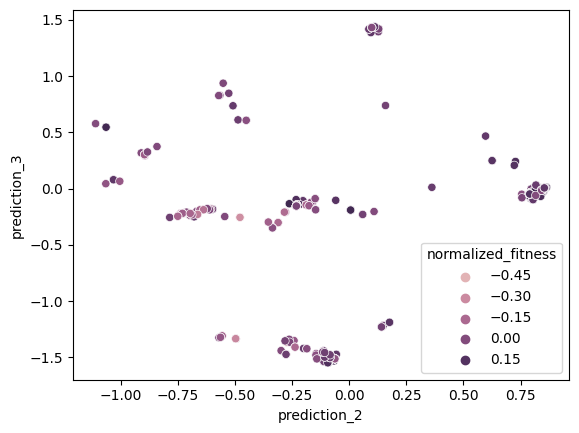

In [83]:
sns.scatterplot(x="prediction_2", y="prediction_3", data=significant_samples, hue="normalized_fitness")

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

<Axes: xlabel='prediction_2', ylabel='prediction_3'>

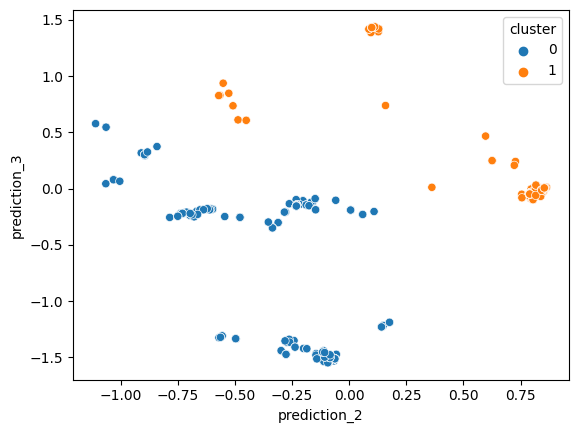

In [76]:
sns.scatterplot(x="prediction_2", y="prediction_3", data=significant_samples, hue="cluster")

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

<Axes: xlabel='prediction_0', ylabel='prediction_3'>

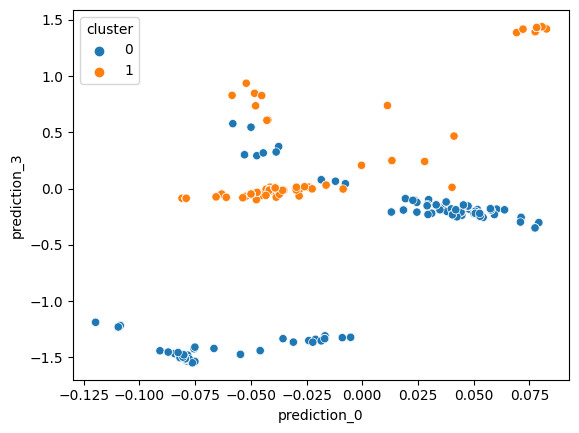

In [77]:
sns.scatterplot(x="prediction_0", y="prediction_3", data=significant_samples, hue="cluster")

In [78]:
significant_samples.sort_values(["mutated_amino_acids", "fitness"]).to_csv("significant_samples.csv")

In [79]:
significant_samples.groupby("cluster")[["fitness", "normalized_fitness"]].mean()

,fitness,normalized_fitness
cluster,,
0,0.497057,-0.060630
1,0.616105,0.085574


cluster
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: normalized_fitness, dtype: object

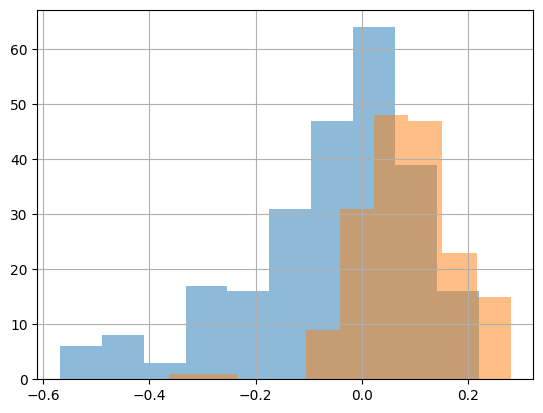

In [80]:
significant_samples.groupby("cluster")["normalized_fitness"].hist(alpha=0.5)

cluster
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: fitness, dtype: object

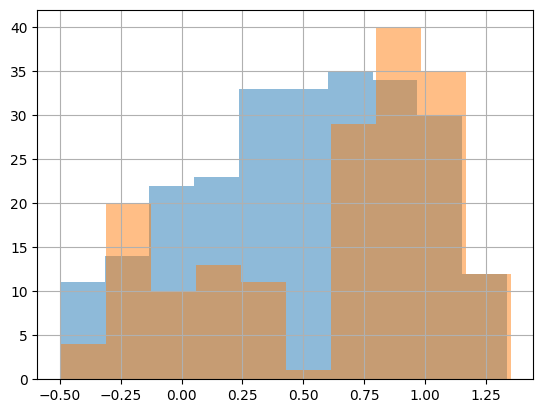

In [81]:
significant_samples.groupby("cluster")["fitness"].hist(alpha=0.5)

significant_samples.groupby("am")

In [82]:
significant_samples.groupby("mutated_amino_acids").apply(lambda x: stats.spearmanr(x["cluster"], x["fitness"])[0] if stats.spearmanr(x["cluster"], x["fitness"])[1] < 0.05 else None).mean()

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


0.6518557290639364